In our model, $\rho_{ch}(r)$ has the form of a "Saxon-Woods potential":
$$ \rho_{ch}(r) = \frac{\rho_{ch}^0}{1 + e^{(r-R)/\alpha}} $$
where R is the charge radius of the nucleous and $\alpha$ is the surface depth. $\rho_{ch}^0$ is a normalization parameter, which is derived from the following formula:
$$ 4\pi \int\limits_0^{\infty} \rho_{ch}(r) dr = Z \Rightarrow \rho_{ch}^0 = \frac{Z}{4\pi(R + \alpha ln(1 + e^{R/\alpha}))}$$


The formula of the electron scattering experiment is the following:
$$ \frac{d\sigma}{d\Omega} = \left(\frac{E}{2\pi}\right)^2 \left(\frac{1}{\hbar c}\right)^4 \frac{1}{q^4} \left( \frac{e^2}{\epsilon_0} \int \rho_{ch}(\vec{r}) e^{i \vec{q} \cdot \vec{r}} d^3 \vec{r} \right)^2$$ 

The first step in order to manage the integral is setting $\vec{q} \cdot \vec{r} = q r sin\theta'$. So:
$$ \int \rho_{ch}(\vec{r}) e^{i \vec{q} \cdot \vec{r}} d^3 \vec{r} = \int\limits_{r=0}^{\infty} \int\limits_{\phi=0}^{2\pi} \int\limits_{\theta' =0}^{\pi} \rho_{ch}(r) e^{iqrcos\theta'}r^2 sin\theta' d\theta' d\phi dr = 2\pi \int\limits_{r=0}^{\infty}\left( \rho_{ch}(r) r^2 \int\limits_{\theta' =0}^{\pi} e^{iqrcos\theta'} sin\theta' d\theta'\right)dr$$

$$\int\limits_{\theta' =0}^{\pi} e^{iqrcos\theta'} sin\theta' d\theta'  = \frac{2sin(q\cdot r)}{q \cdot r}$$
where q is found to be:
$$ q = \frac{2E}{\hbar c} sin(\frac{\theta}{2})$$
So, the final integral is the following:
$$ \int \rho_{ch}(\vec{r}) e^{i \vec{q} \cdot \vec{r}} d^3 \vec{r} = \frac{4\pi}{q} \int\limits_0^{\infty}\left(\rho_{ch}(r)\cdot r \cdot sin(qr)\right) dr$$
$$ I =  \int\limits_0^{\infty}\left(\rho_{ch}(r)\cdot r \cdot sin(qr)\right) dr$$
$$ \frac{d\sigma}{d\Omega} = \left(\frac{2 E e^2 I}{(\hbar c)^2 q^3 \epsilon_0}\right)^2$$
By using the formula of the fine-structure constant:
$$ fsc = \frac{e^2}{4 \pi \epsilon_0 \hbar c} \approx \frac{1}{137}$$
We obtain the final formula:
$$ \frac{d\sigma}{d\Omega} = \left(\frac{8 \pi \cdot \text{fsc} \cdot E  I}{\hbar c \cdot q^3}\right)^2$$

Therefore, the goal of this project is to find the optimal parameters R and $\alpha$ where the approximated values match the experimental data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook','grid'])
from scipy.integrate import quad
import pandas as pd
from numba import njit

In [2]:
hbarc = 197 # MeV fm
Z = 79 # Au
fsc = 1/137

In [3]:
@njit(fastmath=True)
def rho_ch(r,R,a,Z):
    rho0 = 4*np.pi*(R+a*np.log(1+np.exp(-R/a)))
    rho0 = Z/rho0
    return rho0/(1+np.exp((r-R)/a))

@njit(fastmath=True)
def q_function(E,theta): 
    # theta on degrees.
    hbarc = 197 #MeV fm
    return 2*E/hbarc * np.sin(np.deg2rad(theta/2))

@njit(fastmath=True)
def calculating_cross_section(E,theta,R,a,Z):
    hbarc = 197 # MeV fm
    fsc = 1/137
    rho = lambda r: rho_ch(r,R,a,Z)
    q = q_function(E,theta) 
    integral = lambda r: rho(r)*r*np.sin(q*r)
    values = np.linspace(0,30,500000)
    integral_values = integral(values)
    I = np.trapezoid(integral_values,values,)
    #I = quad(integral, 0,40)[0]
    ds = 8*np.pi*fsc*E*I/(hbarc*q**3)
    ds = ds**2
    return ds

In [67]:
calculating_cross_section(E1,48,6,0.5,79)

np.float64(0.12198001806242496)

In [4]:
df1 = pd.read_csv('data183MeV.csv', header=None)
E1 = 183 #MeV
df2 = pd.read_csv('data126MeV.csv', header=None)
E2 = 126 #MeV

In [5]:
th1 = df1[0].to_numpy()
ds1 = df1[1].to_numpy()
th2 = df2[0].to_numpy()
ds2 = df2[1].to_numpy()

In [6]:
@njit(fastmath=True)
def calculating_best_fit(E,th,ds,Z):
    R_array = np.arange(6.0,7.0+0.01,0.01,dtype=np.float64)
    a_array = np.arange(0.3, 1.2+0.01, 0.01,dtype=np.float64)  
    rmsemin =np.inf
    Rmin = 1.0
    amin = 1.0
    inv_n = 1.0 / len(th)
    ds_hat = np.zeros(len(th))
    for R in R_array:
        for a in a_array:
            for i in range(len(th)):
                ds_hat[i]=calculating_cross_section(E,th[i],R,a,Z)
            rmse = np.sqrt(inv_n*np.sum((ds - ds_hat)**2))
            if rmse < rmsemin:
                rmsemin = rmse
                Rmin = R
                amin = a
    return np.array([Rmin, amin, rmsemin])

The calculating_best_fit function run on the Aristotelis HPC and returned the best fit values:
$$ R = 6.84$$
$$ \alpha = 1.2$$

(1e-05, 90)

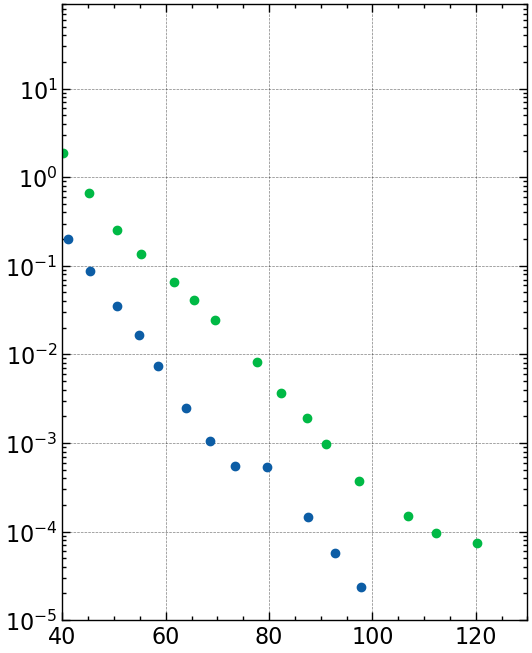

In [14]:
fig = plt.figure(figsize=(6,8))
plt.scatter(th1,ds1)
plt.scatter(th2,ds2)
plt.yscale('log')
plt.xlim([40, 130])
plt.ylim([1e-5,90])

In [7]:
def cross_function(E,R,a,theta):
    rho = lambda r: rho_ch(r,R,a,Z)
    q = q_function(E,theta)
    integral = lambda r: rho(r)*r*np.sin(q*r)
    I = quad(integral,0,40)[0]
    ds = (8 * np.pi * fsc * E * I)/(hbarc * q**3)
    ds = ds**2
    return ds

In [8]:
th_array = np.linspace(40,100,100)
th_array2 = np.linspace(40,120,200)

In [9]:
ds_array = np.zeros(len(th_array))
for i in range(len(th_array)):
    ds_array[i] = cross_function(E1,6.84,1.2,th_array[i])

ds_array2 = np.zeros(len(th_array2))
for i in range(len(th_array2)):
    ds_array2[i] = cross_function(E2,6.84,1.2,th_array2[i])

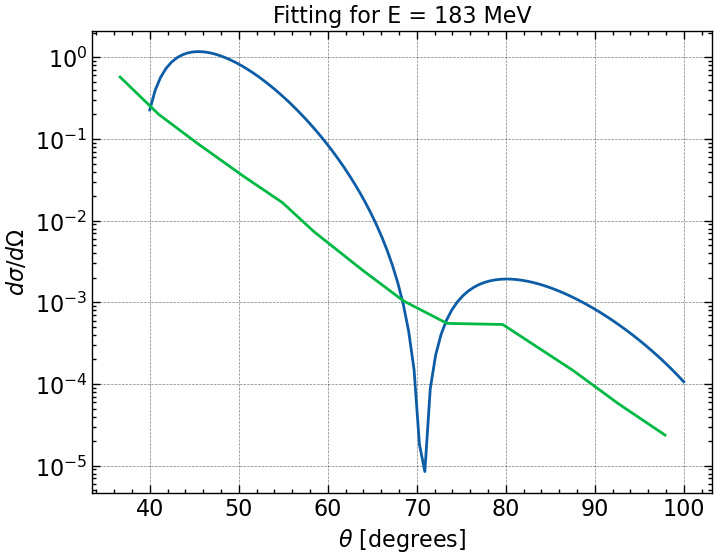

In [15]:
plt.plot(th_array,ds_array)
plt.title('Fitting for E = 183 MeV')
plt.xlabel(r'$\theta$ [degrees]')
plt.ylabel('$d\sigma / d\Omega$')
plt.plot(th1,ds1)
plt.yscale('log')
plt.show()

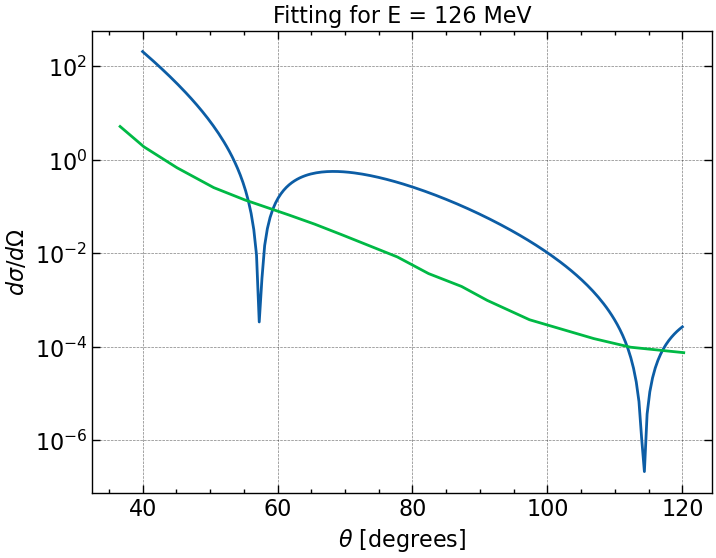

In [16]:
plt.plot(th_array2,ds_array2)
plt.plot(th2,ds2)
plt.title('Fitting for E = 126 MeV')
plt.xlabel(r'$\theta$ [degrees]')
plt.ylabel('$d\sigma / d\Omega$')
plt.yscale('log')
plt.show()